# 02- Exploratory Data Analysis (EDA)

In [1]:
import pickle
from collections import Counter

import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from gensim.models import Word2Vec

In [2]:
df = pd.read_pickle('../data/cleaned_tweets_test.pkl')

In [3]:
df.head()

,text,label,category,cleaned,num_words
0,we are living in scary times in canada. gov’t ...,0,unreliable,living scary time canada gov refuse protect ca...,9
1,"just as bad in canada. in fact, our government...",0,unreliable,bad canada fact government accusing us racism ...,10
2,it was only a matter of time before the mainst...,0,unreliable,matter time mainstream medium decided blame co...,10
3,russia's taking no chances: foreigners infecte...,0,unreliable,russia taking chance foreigner infected new ch...,13
4,although there is now a presumptive confirmed ...,0,unreliable,although presumptive confirmed case wuhan nove...,11


In [4]:
df.label.value_counts()

0    280
1    277
Name: label, dtype: int64

In [5]:
df.category.value_counts()

unreliable    280
true          277
Name: category, dtype: int64

#### distribution of number of words in a tweet per true / unreliable category

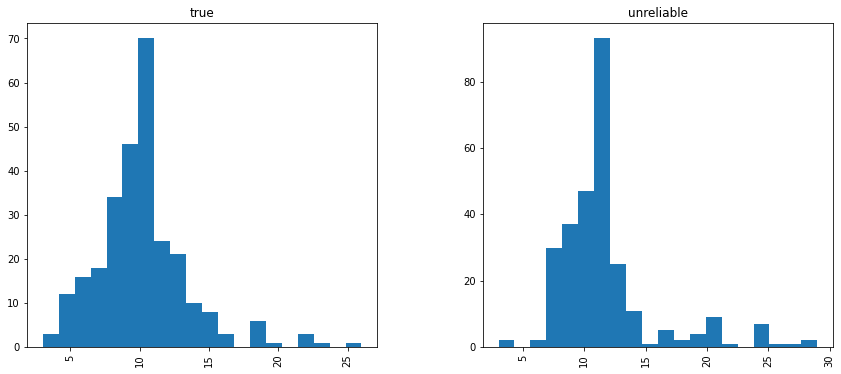

In [6]:
df.num_words.hist(by=df.category, figsize=(14,6), bins=20)
plt.show()


#### count of (non distinct) words in each category

In [7]:
bow_true = []
for word in df[df.category == 'true'].cleaned.str.split().to_list():
    bow_true += word


In [8]:
bow_unreliable = []
for word in df[df.category == 'unreliable'].cleaned.str.split().to_list():
    bow_unreliable += word

In [9]:
len(bow_true)

2829

In [10]:
len(bow_unreliable)

3294

#### most common words in each category

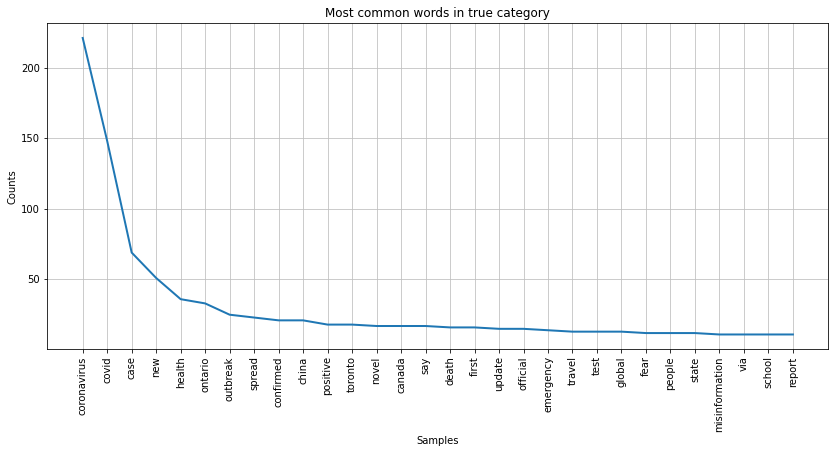

In [11]:
plt.figure(figsize=(14,6))
nltk.FreqDist(bow_true).plot(30,
                             title='Most common words in true category')
plt.show()

In [12]:
Counter(bow_true).most_common(100)

[('coronavirus', 221),
 ('covid', 148),
 ('case', 69),
 ('new', 51),
 ('health', 36),
 ('ontario', 33),
 ('outbreak', 25),
 ('spread', 23),
 ('confirmed', 21),
 ('china', 21),
 ('positive', 18),
 ('toronto', 18),
 ('novel', 17),
 ('canada', 17),
 ('say', 17),
 ('death', 16),
 ('first', 16),
 ('update', 15),
 ('official', 15),
 ('emergency', 14),
 ('travel', 13),
 ('test', 13),
 ('global', 13),
 ('fear', 12),
 ('people', 12),
 ('state', 12),
 ('misinformation', 11),
 ('via', 11),
 ('school', 11),
 ('report', 11),
 ('breaking', 11),
 ('pandemic', 11),
 ('us', 11),
 ('news', 11),
 ('time', 11),
 ('public', 10),
 ('march', 10),
 ('york', 10),
 ('declares', 10),
 ('amid', 10),
 ('due', 10),
 ('canadian', 10),
 ('virus', 9),
 ('home', 9),
 ('man', 9),
 ('number', 9),
 ('community', 8),
 ('wuhan', 8),
 ('infection', 8),
 ('could', 8),
 ('tested', 8),
 ('stop', 8),
 ('conference', 8),
 ('system', 8),
 ('patient', 7),
 ('concern', 7),
 ('italy', 7),
 ('th', 7),
 ('total', 7),
 ('province', 7),


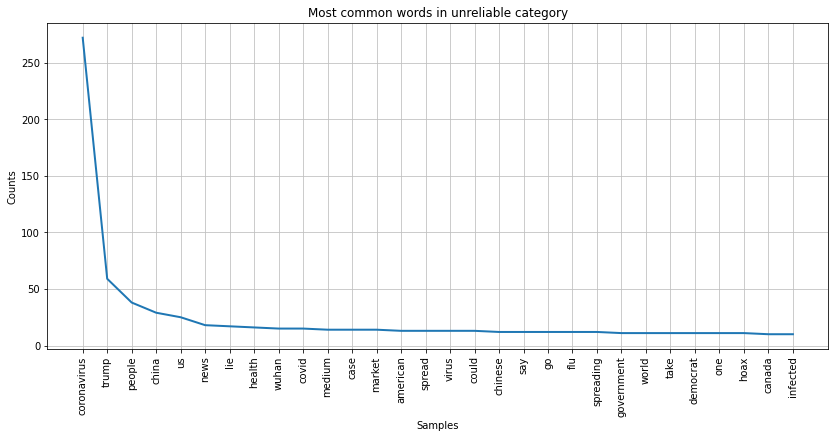

In [13]:
plt.figure(figsize=(14,6))
nltk.FreqDist(bow_unreliable).plot(30,
                             title='Most common words in unreliable category')
plt.show()

In [14]:
Counter(bow_unreliable).most_common(100)

[('coronavirus', 272),
 ('trump', 59),
 ('people', 38),
 ('china', 29),
 ('us', 25),
 ('news', 18),
 ('lie', 17),
 ('health', 16),
 ('wuhan', 15),
 ('covid', 15),
 ('medium', 14),
 ('case', 14),
 ('market', 14),
 ('american', 13),
 ('spread', 13),
 ('virus', 13),
 ('could', 13),
 ('chinese', 12),
 ('say', 12),
 ('go', 12),
 ('flu', 12),
 ('spreading', 12),
 ('government', 11),
 ('world', 11),
 ('take', 11),
 ('democrat', 11),
 ('one', 11),
 ('hoax', 11),
 ('canada', 10),
 ('infected', 10),
 ('new', 10),
 ('amp', 10),
 ('iran', 10),
 ('lying', 10),
 ('stock', 10),
 ('cdc', 10),
 ('like', 9),
 ('think', 9),
 ('outbreak', 9),
 ('video', 9),
 ('president', 9),
 ('get', 9),
 ('everyone', 9),
 ('fake', 9),
 ('know', 8),
 ('make', 8),
 ('stop', 8),
 ('trying', 8),
 ('said', 8),
 ('would', 8),
 ('vaccine', 8),
 ('real', 8),
 ('public', 7),
 ('man', 7),
 ('see', 7),
 ('kill', 7),
 ('going', 7),
 ('penny', 7),
 ('pandemic', 7),
 ('called', 7),
 ('country', 7),
 ('time', 6),
 ('want', 6),
 ('econ

#### Word Cloud

In [15]:
wc_true = WordCloud().generate_from_frequencies(nltk.FreqDist(bow_true))
wc_unreliable = WordCloud().generate_from_frequencies(nltk.FreqDist(bow_unreliable))

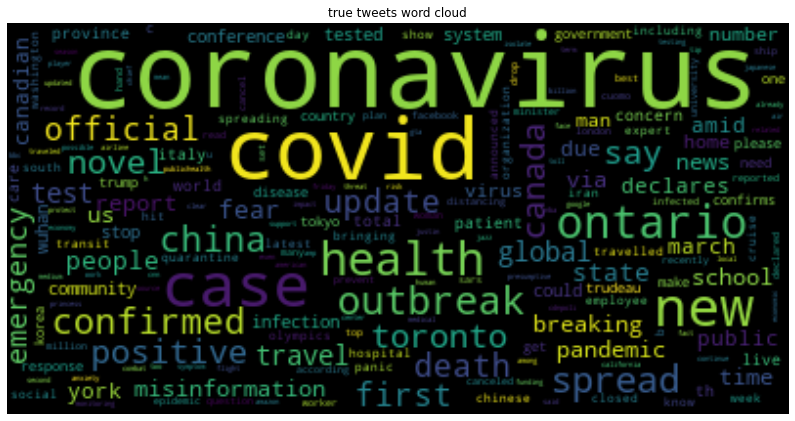

In [16]:
plt.figure(figsize=(14,8))
plt.imshow(wc_true, interpolation='bilinear')
plt.title('true tweets word cloud')
plt.axis('off')
plt.show()

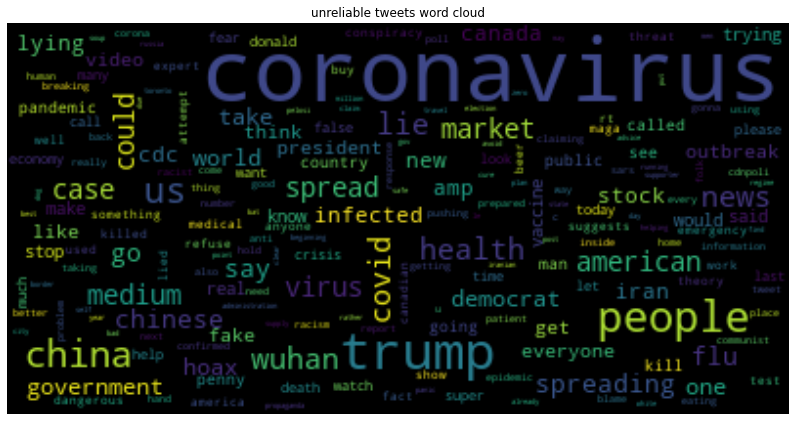

In [17]:
plt.figure(figsize=(14,8))
plt.imshow(wc_unreliable, interpolation='bilinear')
plt.title('unreliable tweets word cloud')
plt.axis('off')
plt.show()

#### size of vocabulary (distinct words)

In [18]:
len(set(bow_true))

1089

In [19]:
len(set(bow_unreliable))

1583

In [20]:
words = bow_true + bow_unreliable

In [21]:
texts =  [(tweet, cat) for tweet, cat in zip(df.cleaned.to_list(), df.category.to_list())]

In [22]:
tweets, cats = (zip(*texts))

## Word Embeddings

In [23]:
testing_words = set(words)

In [24]:
we_cbow = pickle.load(open('../data/we_cbow_training.pickle', 'rb'))
we_sg = pickle.load(open('../data/we_sg_training.pickle', 'rb'))

In [25]:
training_words = pickle.load(open('../data/training_words_set.pickle', 'rb'))

In [26]:
len([word for word in testing_words if word not in training_words])

# this might create a significant issue

596

In [27]:
def meaner(word_embedding, tweets, training_words):
    # excludes words that are not in the training words
    tweet_embedding = {}
    for i, tweet in enumerate(tweets):
        tweet_embedding[tweet] = np.mean(np.array([word_embedding[word] for word in tweets[i].split() if word in training_words]), axis=0)
    return tweet_embedding

In [28]:
te_cbow = meaner(we_cbow, tweets, training_words)
te_sg = meaner(we_sg, tweets, training_words)

In [29]:
len(te_cbow), len(te_sg)

(557, 557)

In [30]:
te_cbow_df = pd.DataFrame(te_cbow).T.reset_index().rename(columns={'index':'tweet'})
te_cbow_df['category'] = cats
te_cbow_df['label'] = te_cbow_df.category.map({'unreliable':0, 'true':1})
te_cbow_df = te_cbow_df.sample(frac=1, random_state=42).reset_index(drop=True)

te_sg_df = pd.DataFrame(te_sg).T.reset_index().rename(columns={'index':'tweet'})
te_sg_df['category'] = cats
te_sg_df['label'] = te_sg_df.category.map({'unreliable':0, 'true':1})
te_sg_df = te_sg_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [31]:
te_cbow_df.head()

,tweet,0,1,2,3,4,5,6,7,8,...,292,293,294,295,296,297,298,299,category,label
0,nation health professional continue manage cor...,-0.000818,-0.040816,0.004682,-0.074017,0.081909,-0.017330,0.200177,0.185050,-0.080864,...,0.018452,0.099282,0.069747,0.194220,0.285797,0.042815,-0.033978,0.044190,unreliable,0
1,toronto public health set coronavirus hotline ...,-0.002782,-0.051848,0.026428,-0.108414,0.135694,-0.027716,0.328415,0.314705,-0.118441,...,0.029588,0.166246,0.114611,0.320250,0.471024,0.084142,-0.054351,0.077487,true,1
2,hey trumptrain official warns trump ignorant c...,0.000294,-0.055367,0.026422,-0.113652,0.128993,-0.026972,0.314186,0.285075,-0.123907,...,0.034080,0.155918,0.103066,0.311690,0.459205,0.083464,-0.052575,0.077229,unreliable,0
3,lie us coronaviruse,-0.007568,-0.040254,0.018142,-0.081122,0.101827,-0.015538,0.238739,0.242553,-0.089649,...,0.021653,0.125816,0.092094,0.216637,0.317990,0.062334,-0.043741,0.056062,unreliable,0
4,maga hat made china may infected coronavirus s...,-0.007788,-0.044461,0.022584,-0.089702,0.102980,-0.023071,0.259131,0.240636,-0.099773,...,0.023633,0.130142,0.091667,0.264604,0.391263,0.068265,-0.045697,0.063138,unreliable,0


In [32]:
pickle.dump(te_cbow_df, open("../data/te_cbow_df_testing.pickle", "wb"))
pickle.dump(te_sg_df, open("../data/te_sg_df_testing.pickle", "wb"))